In [1]:
import glob
import os
from tqdm import tqdm
import numpy as np
from read_vtk import vtk

from collections.abc import Iterable

datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/test1_bfield/'
outpath = './temp_dashboard/'
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
out_dt_vtk = 0.1
adiab_idx = 1.33333333333

vtk_filenames = sorted(glob.glob(datapath + 'joined_vtk/*.vtk'))

In [2]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

# sychrotron emission treatment
#TODO: change parameters to typical from Malzac models
gmin = 1.0e2
gmax = 1.0e6
p = 2.5
xi_e = 0.5 # electron equipartition parameter, U_e = xi_e* U_B

# choice of emitting region size and frequency for plotting
R_choice = 1.5e10 * u.cm # ~ 10^4rg, see Shidatsu et al. (2011)
nu_choice = 1.4e15 * u.Hz # see Malzac et al. (2018)

# system properties (see overleaf)
beta_jet = 0.75
gamma_jet = 2.0
incl = 23.0 * np.pi / 180.
theta_j = 2.3 * np.pi / 180.
dist = 8. * u.kpc
mbh = 10. * u.Msun

# See Malzac (2014), appendix A

if p != 2.0:
    gamma_e_bar = (1-p)/(2-p) * (gmax**(2-p) - gmin**(2-p)) / (gmax**(1-p) - gmin**(1-p))
else:
    gamma_e_bar = (1-p) * np.log(gmax/gmin) / (gmax**(1-p) - gmin**(1-p))

i_gamma = ( gamma_e_bar * (1/(1-p)) * (gmax**(1-p) - gmin**(1-p)) )**(-1)

K_j = ( (np.sqrt(3.) * e**3 * i_gamma) / (16*np.pi**2 * m_e**2 * c**4 * (p+1)) ) \
    * gamma((3*p+19)/12.) * gamma((3*p-1)/12.) * (m_e*c/(3*e))**(-(p-1)/2.)
    
K_a = ( (np.sqrt(3.) * e**3 * i_gamma) / (64*np.pi**2 * m_e**3 * c**4) ) \
    * (3.*e / (2.*np.pi*m_e*c))**(0.5*p) \
    * gamma((3.*p+2)/12.) * gamma((3.*p+22)/12.)
    
# j_nu, nu in fluid frame
def j_nu (nu_fl, B):
    return (K_j * xi_e * (B*(u.erg/u.cm**3)**0.5)**((p+5)/2.) * (nu_fl*u.Hz)**(-(p-1)/2.)).cgs
def alpha_nu (nu_fl, B):
    return (K_a * xi_e * (B*(u.erg/u.cm**3)**0.5)**(0.5*p+3) * (nu_fl*u.Hz)**(-(p+4)/2.)).cgs
def j_over_alpha_nu (nu_fl, B):
    return ((K_j/K_a) * (B*(u.erg/u.cm**3)**0.5)**(-0.5) * (nu_fl*u.Hz)**(2.5)).cgs
def intensity (nu_fl, B, R):
    # for small alphae, we need to use a Taylor expansion
    alpha = alpha_nu(nu_fl,B)
    return np.where(
        alpha*R*u.cm < 1.0e-6,
        j_nu(nu_fl, B) * R*u.cm,
        j_over_alpha_nu(nu_fl, B) * (1.0-np.exp(-alpha*R*u.cm))
    )
    
# observables
doppler_factor = 1.0 / (gamma_jet*(1.0-beta_jet*np.cos(incl)))
def nu2nu_fl (nu):
    return nu/doppler_factor
def flux_nu (nu, B, R, dS, filling_factor=1.0):
    return (doppler_factor**2 * gamma_jet / (2.*dist**2)) \
             * filling_factor* intensity(nu/doppler_factor,B,R) \
             * (dS*u.cm**2) # perp. surface element, instead of (beta c dt R)
# total flux within the IR-opt range: 300GHz - 3PHz
def flux_total (B,R,dS, nu_min=300.0e9, nu_max=3.0e15, resolution=1024):
    if not isinstance(B, Iterable):
        B = np.array([B,])
    Bshape = B.shape
    # log-integrate the flux
    lognu = np.linspace(np.log(nu_min), np.log(nu_max), resolution)
    dlognu = lognu[1:] - lognu[:-1]
    lognu = 0.5 * (lognu[1:] + lognu[:-1])
    nu = np.exp(lognu)
    B_grid, nu_grid = np.meshgrid(B, nu, indexing='ij')
    B_grid, dlognu_grid = np.meshgrid(B, dlognu, indexing='ij')
    integrand = nu_grid*u.Hz * flux_nu(nu_grid,B_grid,R,dS).cgs
    return np.sum(integrand*dlognu_grid, axis=-1).reshape(Bshape).cgs

In [3]:
print(j_nu(12., 12.))
print(alpha_nu(12., 12.))
print(intensity(12., 12.,12.))
print("Check that dimensionless: ", (j_over_alpha_nu(12., 12.) / (u.erg / (u.cm**2))).cgs,
      flux_total(12.,12.,0.5).cgs / (u.erg/(u.cm**2*u.s)).cgs)

2.540471985544853e-09 P / s
1.033423254591124e+19 1 / cm
2.458307353021581e-28 cm P / s
Check that dimensionless:  2.458307353021581e-28 [1.6052244e-47]


In [16]:
def do_vertical_avg (data_vtk, quantity):
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    data_vtk[quantity+'_vsZ'] = np.sum(data_vtk[quantity], axis=0) / yrange
    
default_augment_kwargs = {
    'nu_res':128, 'nu_min':1., 'nu_max':3.0e15,
    'nu_int_min':300.0e9, 'nu_int_max':3.0e15,
    'R_selection':6.0e8, 'nu_selection':1.4e15, 'filling_factor':1.0
}

def augment_vtk_data (data_vtk, previous_data_vtk=None, 
                      nu_res=128, nu_min=1., nu_max=3.0e15,
                      nu_int_min=300.0e9, nu_int_max=3.0e15,
                      R_selection=6.0e8, nu_selection=1.4e15, filling_factor=1.0):
    
    ''' calculate auxiliary data '''
    
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    
    # SR quantities
    # NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
    vel_tot_sqr = data_vtk['vel1']**2 + data_vtk['vel2']**2 + data_vtk['vel3']**2
    data_vtk['vel_tot'] = np.sqrt(vel_tot_sqr)
    data_vtk['gamma'] = 1./np.sqrt(1.-vel_tot_sqr)
    del vel_tot_sqr

    # total Bcc in observer frame
    data_vtk['Bcc_tot'] = np.sqrt(data_vtk['Bcc1']**2 + data_vtk['Bcc2']**2 + data_vtk['Bcc3']**2)

    # Bcc in the fluid frame
    data_vtk['Bcc_fluid_0'] = data_vtk['gamma'] * (data_vtk['vel1']*data_vtk['Bcc1'] + data_vtk['vel2']*data_vtk['Bcc2'] + data_vtk['vel3']*data_vtk['Bcc3'])
    data_vtk['Bcc_fluid_1'] = data_vtk['Bcc1'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel1']
    data_vtk['Bcc_fluid_2'] = data_vtk['Bcc2'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel2']
    data_vtk['Bcc_fluid_3'] = data_vtk['Bcc3'] / data_vtk['gamma'] + data_vtk['Bcc_fluid_0'] * data_vtk['vel3']
    Bcc_fluid_tot_sqr = data_vtk['Bcc_fluid_1']**2 + data_vtk['Bcc_fluid_2']**2 + data_vtk['Bcc_fluid_3']**2
    data_vtk['Bcc_fluid_tot'] = np.sqrt(Bcc_fluid_tot_sqr)
    do_vertical_avg(data_vtk, 'Bcc_fluid_tot')

    # plasma parameters
    data_vtk['plasma_beta'] = 2.*data_vtk['press'] / Bcc_fluid_tot_sqr
    data_vtk['magnetization'] = Bcc_fluid_tot_sqr / data_vtk['rho']
    del Bcc_fluid_tot_sqr
    
    # internal energy in the fluid frame, see Beckwith & Stone (2011)
    data_vtk['enthalpy'] = 1.0 + ((adiab_idx)/(adiab_idx-1.0)) * data_vtk['press'] / data_vtk['rho']
    data_vtk['internal_energy'] = data_vtk['rho'] * data_vtk['enthalpy'] * data_vtk['gamma']**2 - data_vtk['press'] + 0.5 * data_vtk['Bcc_fluid_tot']**2 # warning!: includes rest mass
    do_vertical_avg(data_vtk, 'internal_energy')
    
    # synchrotron emission diagnostics
    data_vtk['j_nu'] = j_nu(nu2nu_fl(nu_selection), data_vtk['Bcc_fluid_tot'])
    do_vertical_avg(data_vtk, 'j_nu')
    data_vtk['j_over_alpha_nu'] = j_over_alpha_nu(nu2nu_fl(nu_selection), data_vtk['Bcc_fluid_tot'])
    do_vertical_avg(data_vtk, 'j_over_alpha_nu')
    dS = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    data_vtk['flux_total'] = flux_total(B=data_vtk['Bcc_fluid_tot'], R=R_selection, dS=dS, nu_min=nu_int_min, nu_max=nu_int_max)
    data_vtk['flux_density'] = (data_vtk['flux_total'] / dS).value
    do_vertical_avg(data_vtk, 'flux_total')
    freqs = np.logspace(np.log10(nu_min), np.log10(nu_max), nu_res)
    nu_grid, B_grid = np.meshgrid(freqs, data_vtk['Bcc_fluid_tot'], indexing='ij')
    data_vtk['spectrum'] = [
        freqs,
        np.nansum(flux_nu(nu=nu_grid, B=B_grid, R=R_selection, dS=dS, filling_factor=filling_factor), axis=-1) / yrange
    ]
    
    # time derivatives
    if type(previous_data_vtk) is dict:
        for quantity in ['internal_energy','internal_energy_vsZ']:
            data_vtk['ddt_'+quantity] = (data_vtk[quantity]-previous_data_vtk[quantity]) / (data_vtk['Time']-previous_data_vtk['Time'])
    
    return data_vtk

def precalc_history (vtk_filenames, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs):
    previous_data_vtk = None
    history = {}
    quantities = ['times', 'ddt_internal_energy', 'flux_total']
    for quantity in quantities:
        history[quantity] = []
    for vtk_filename in tqdm(vtk_filenames):
        fileno = int(vtk_filename.split('/')[-1].split('.')[-2])
        # read and augment the data
        data_vtk = augment_vtk_data(vtk(vtk_filename, out_dt=out_dt_vtk), previous_data_vtk=previous_data_vtk, **augment_kwargs)
        # calculate history variables
        history['times'].append(fileno*out_dt)
        dl = (data_vtk['x1v'][1] - data_vtk['x1v'][0])
        if 'ddt_internal_energy' in data_vtk.keys():
            history['ddt_internal_energy'].append(np.sum(data_vtk['ddt_internal_energy_vsZ']*dl))
        else:
            history['ddt_internal_energy'].append(np.nan)
        history['flux_total'].append(np.sum(data_vtk['flux_total_vsZ']*dl).cgs.value)
        # move on
        del previous_data_vtk
        previous_data_vtk = data_vtk
    for quantity in quantities:
        history[quantity] = np.array(history[quantity])
    return history

# WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
def dashboard_frame (i_vtk, verbose=False, save=True, recalculate=False, previous_data_vtk=None, history=None, augment_kwargs=default_augment_kwargs):

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    from read_vtk import vtk
    
    fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[-2])
    vtk_time = fileno * out_dt_vtk # presumably we can trust this..
    
    print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)
    
    # see whether we can skip the file as already plotted
    outfile = (outpath + 'dashboard_%05i.png') % fileno
    if save and not recalculate and os.path.exists(outfile):
        print(' - file already plotted, skipping.', flush=True)
        return

    # initialize the plot
    fig = plt.figure(figsize=(24,12))
    gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
    plt.suptitle('Time = %.2f sim.u.' % vtk_time)

    # ----------------------------------------------------------

    if verbose:
        print(' - processing vtk data..', flush=True)

    # load, process, and plot the vtk file (mhd quantities)
    
    if previous_data_vtk == None and i_vtk > 0:
        previous_data_vtk = augment_vtk_data(vtk(vtk_filenames[i_vtk-1], out_dt=out_dt_vtk), **augment_kwargs)

    data_vtk = augment_vtk_data(vtk(vtk_filenames[i_vtk], out_dt=out_dt_vtk), previous_data_vtk=previous_data_vtk, **augment_kwargs)

    # plot

    plt.subplot(gs[0,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.title('Magnetization (fl. frame)')
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,1]))

    plt.subplot(gs[1,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['Bcc_fluid_tot'])
    plt.title('Bfield (fl. frame) [sim.u.]')
    plt.ylabel('y [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.colorbar(cax=plt.subplot(gs[1,1]))
    
    ax = plt.subplot(gs[2,0])
    plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.title('Bfield (fl. frame) [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

    ax = plt.subplot(gs[3,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['plasma_beta'])
    plt.title('Plasma $\\beta$')
    plt.ylabel('y [sim.u.]')
    plt.xlabel('x [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[3,1]))
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

    plt.subplot(gs[0,3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'])
    plt.title('Density (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,4]))

    plt.subplot(gs[1,3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'])
    plt.title('Syn. flux / dS [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,4]))
    
    ax = plt.subplot(gs[2,3])
    plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('$j_{\\nu}(1.4\\times10^{15}$ Hz$ )$ [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax2 = plt.twinx()
    plt.plot(data_vtk['x1v'], data_vtk['j_over_alpha_nu_vsZ'], 'b-')
    plt.ylabel('$j_{\\nu}/\\alpha_{\\nu}(1.4\\times10^{15}$ Hz$ )$ [sim.u.]')
    
    plt.subplot(gs[0,6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['internal_energy'])
    plt.title('Internal energy, $U$ (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,7]))

    plt.subplot(gs[1,6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['ddt_internal_energy'])
    plt.title('d(Internal energy)/dt, $\\dot{U}$ (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,7]))
    
    ax = plt.subplot(gs[2,6])
    plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('$U$ [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax2 = plt.twinx()
    plt.plot(data_vtk['x1v'], data_vtk['ddt_internal_energy_vsZ'], 'b-')
    plt.ylabel('$\\dot{U}_{\\rm avg}$ [sim.u.]')
    
    ax = plt.subplot(gs[3,6])
    plt.plot(data_vtk['spectrum'][0], data_vtk['spectrum'][1], 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('$\\nu$ [sim.u.]')
    plt.ylabel('$F_{\\nu\\rm,syn}$ [sim.u.]')
    plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
    plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')
    
    # set the plot range to vtk data
    for j in range(2):
        for i in range(3):
            ax = plt.subplot(gs[j,3*i])
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
            ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))
            
    # plot the history data
    if type(history) == dict:
        ax = plt.subplot(gs[3,3])
        mask = history['times'] < vtk_time
        plt.plot(history['times'][mask], history['ddt_internal_energy'][mask], 'r-')
        mask = history['times'] == vtk_time
        plt.scatter(history['times'][mask], history['ddt_internal_energy'][mask], color='r', s=8)
        mask = history['times'] > vtk_time
        plt.plot(history['times'][mask], history['ddt_internal_energy'][mask], 'r:')
        plt.ylabel('$\int\dot{U}_{\\rm avg}dz$ [sim.u.]')
        plt.xlabel('Time [sim.u.]')
        ax2 = plt.twinx()
        mask = history['times'] < vtk_time
        plt.plot(history['times'][mask], history['flux_total'][mask], 'b-')
        mask = history['times'] == vtk_time
        plt.scatter(history['times'][mask], history['flux_total'][mask], color='b', s=8)
        mask = history['times'] > vtk_time
        plt.plot(history['times'][mask], history['flux_total'][mask], 'b:')
        plt.ylabel('Syn. flux / dy [sim.u.]')

    # clean up
    del data_vtk

    if verbose:
        print('     done.', flush=True)

    #plt.tight_layout()
    if save:
        plt.savefig(outfile, format='png', dpi=300, facecolor='w')
    else:
        plt.show()
    plt.close()
    
    print(' - frame done.', flush=True)

In [7]:
history = precalc_history(vtk_filenames, out_dt=out_dt_vtk)

  0%|          | 0/401 [00:00<?, ?it/s]/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 401/401 [05:42<00:00,  1.17it/s]


Processing vtk no 80, vtk_time = 8.00e+00..


/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:224: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be

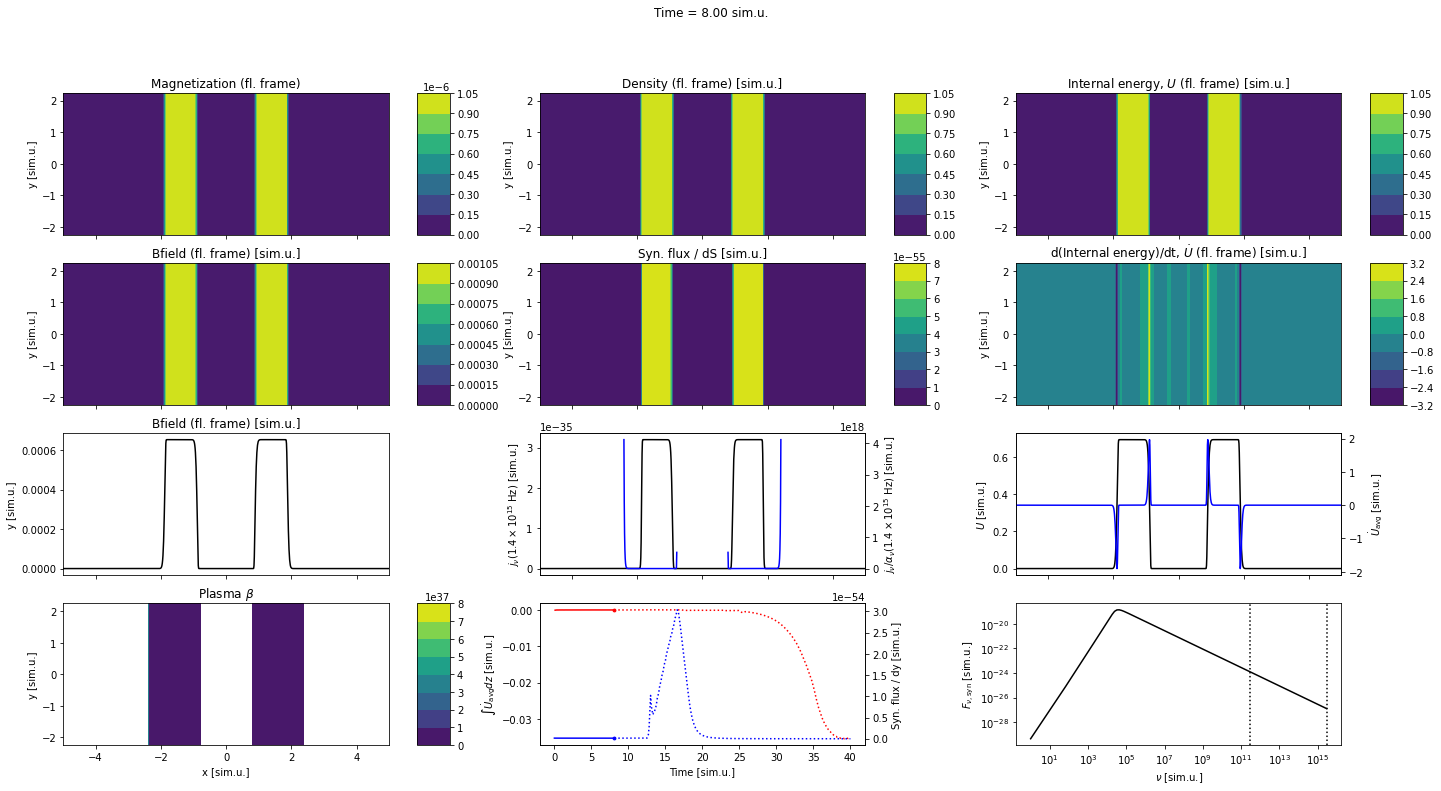

 - frame done.


In [17]:
dashboard_frame(80, save=False, history=history)